## How to create an instance of the pre-built two dof, six muscles arm with rigid tendons
This notebook outlines how to build a 2-DOF, 6-muscles (rigid tendon) arm as a standalone object, that is, that is not
plugged to a deep net.

In [4]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys

# find root directory and add to path
root_index = os.getcwd().rfind('MotorNet') + len('MotorNet') + 1
root_directory = os.path.dirname(os.getcwd()[:root_index])
sys.path.append(root_directory)

from MotorNet.plants import RigidTendonArm
from MotorNet.plants.muscles import RigidTendonHillMuscleThelen
from MotorNet.utils.plotor import plot_pos_over_time


%load_ext autoreload
%autoreload 2

# tf.debugging.enable_check_numerics()
print('tensorflow version: ' + tf.__version__)
print('numpy version: ' + np.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
tensorflow version: 2.6.0
numpy version: 1.21.2


simulation duration: 0.29699999999138527 sec


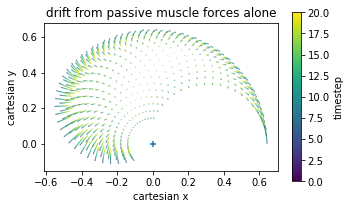

In [5]:
arm = RigidTendonArm(muscle_type=RigidTendonHillMuscleThelen())

sho, elb = np.meshgrid(
    np.linspace(arm.pos_lower_bound[0], arm.pos_upper_bound[0], 21).astype('float32'),
    np.linspace(arm.pos_lower_bound[1], arm.pos_upper_bound[1], 21).astype('float32'))
z = tf.zeros_like(sho.reshape(-1))


ex = tf.zeros((sho.size, arm.n_muscles)) * [0, 0, 0, 0, 0, 0]
state0 = arm.get_initial_state(joint_state=tf.stack([sho.reshape(-1), elb.reshape(-1), z, z], axis=1))
c_results = state0[1][:, tf.newaxis, :]
m_results = state0[2][:, tf.newaxis, :, :]
states = state0

start = time.monotonic()
# 200 ms simulation to assess drift
for _ in range(int(0.2 / arm.dt)):
    states = arm(ex, states[0], states[-2], states[-1])
    c_results = tf.concat([c_results, states[1][:, tf.newaxis, :]], axis=1)
    m_results = tf.concat([m_results, states[2][:, tf.newaxis, :, :]], axis=1)
print('simulation duration: ' + str(time.monotonic() - start) + ' sec')

plt.figure(figsize=(5, 3)).set_tight_layout(True)
plot_pos_over_time(cart_results=c_results)
plt.title('drift from passive muscle forces alone')

mstate = state0[-2].numpy().reshape((21, 21, 7, 6))
gstate = state0[-1].numpy().reshape((21, 21, 4, 6))

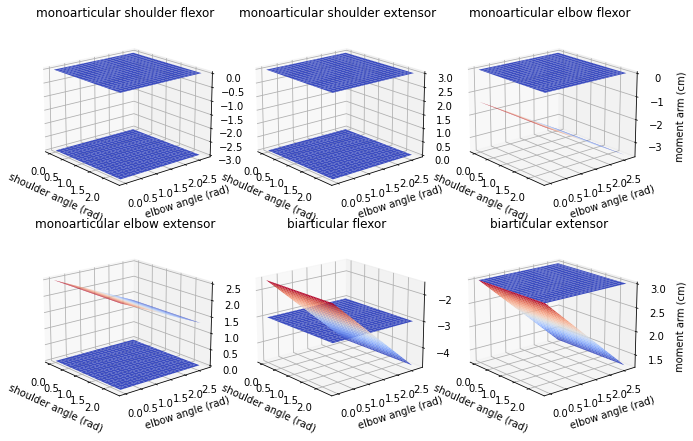

In [6]:
muscles = ['monoarticular shoulder flexor',
           'monoarticular shoulder extensor',
           'monoarticular elbow flexor',
           'monoarticular elbow extensor',
           'biarticular flexor',
           'biarticular extensor']

fig = plt.figure(figsize=(9, 6))
fig.set_tight_layout(True)
for m in range(6):
    ax = fig.add_subplot(2, 3, m+1, projection='3d')
    ax.plot_surface(sho, elb, gstate[:, :, 2, m] * 100, cmap=plt.get_cmap('coolwarm'))
    ax.plot_surface(sho, elb, gstate[:, :, 3, m] * 100, cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('shoulder angle (rad)')
    ax.set_ylabel('elbow angle (rad)')
    ax.set_zlabel('moment arm (cm)')
    ax.view_init(18, -40)
    ax.locator_params(nbins=6)
    plt.title(muscles[m])
plt.show()

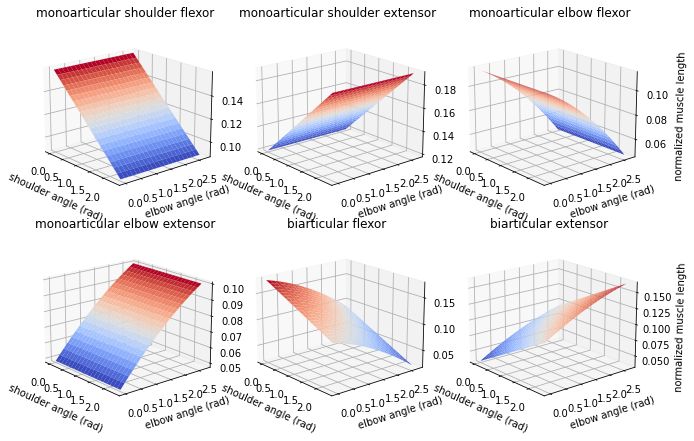

In [7]:
fig = plt.figure(figsize=(9, 6))
fig.set_tight_layout(True)
for m in range(6):
    ax = fig.add_subplot(2, 3, m+1, projection='3d')
    ax.plot_surface(sho, elb, mstate[:, :, 1, m], cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('shoulder angle (rad)')
    ax.set_ylabel('elbow angle (rad)')
    ax.set_zlabel('normalized muscle length')
    ax.view_init(18, -40)
    ax.locator_params(nbins=6)
    plt.title(muscles[m])
plt.show()

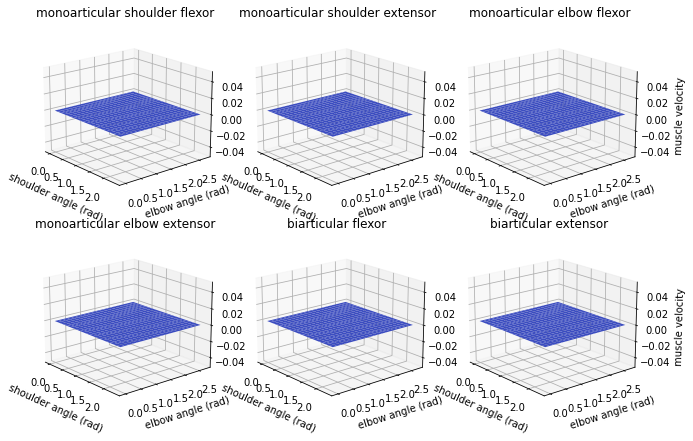

In [8]:
fig = plt.figure(figsize=(9, 6))
fig.set_tight_layout(True)
for m in range(6):
    ax = fig.add_subplot(2, 3, m+1, projection='3d')
    ax.plot_surface(sho, elb, mstate[:, :, 2, m], cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('shoulder angle (rad)')
    ax.set_ylabel('elbow angle (rad)')
    ax.set_zlabel('muscle velocity')
    ax.view_init(18, -40)
    ax.locator_params(nbins=6)
    plt.title(muscles[m])
plt.show()
